In [3]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

In [4]:
# Load environment variables
load_dotenv()

# Database Configuration
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")

def connect_db():
    """Connects to the PostgreSQL database and returns a connection."""
    try:
        conn = psycopg2.connect(
            dbname=DB_NAME, user=DB_USER, password=DB_PASSWORD, host=DB_HOST, port=DB_PORT
        )
        return conn
    except Exception as e:
        print(f"Database connection error: {e}")
        return None


In [5]:
def fetch_stock_data(ticker):
    """Fetches stock OHLCV data and technical indicators from the database."""
    conn = connect_db()
    if not conn:
        return None

    query = f"""
        SELECT date, open, high, low, close, volume, sma_20, ema_20, rsi_14, macd, macd_signal, macd_hist, bb_upper, bb_middle, bb_lower
        FROM stock_analysis_view
        WHERE ticker = '{ticker}'
        ORDER BY date;
    """

    df = pd.read_sql(query, conn)
    conn.close()
    return df

# Example usage:
ticker = "AAPL"  # Change this to any stock ticker
df = fetch_stock_data(ticker)
df.head()


/var/folders/j5/t8_ztn753k55q2jbgyryk3kr0000gn/T/ipykernel_47302/3988839317.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,date,open,high,low,close,volume,sma_20,ema_20,rsi_14,macd,macd_signal,macd_hist,bb_upper,bb_middle,bb_lower
0,2023-01-03,128.782657,129.395526,122.742880,123.632538,112117500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-04,125.431622,127.181283,123.642427,124.907715,89113600,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-05,125.668849,126.301493,123.326093,123.583099,80962700,NaN,NaN,92.600706,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-06,124.561717,128.792516,123.454587,128.130219,87754700,NaN,NaN,94.189981,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-09,128.970458,131.876670,128.397123,128.654129,70790800,NaN,NaN,94.340804,NaN,NaN,NaN,NaN,NaN,NaN


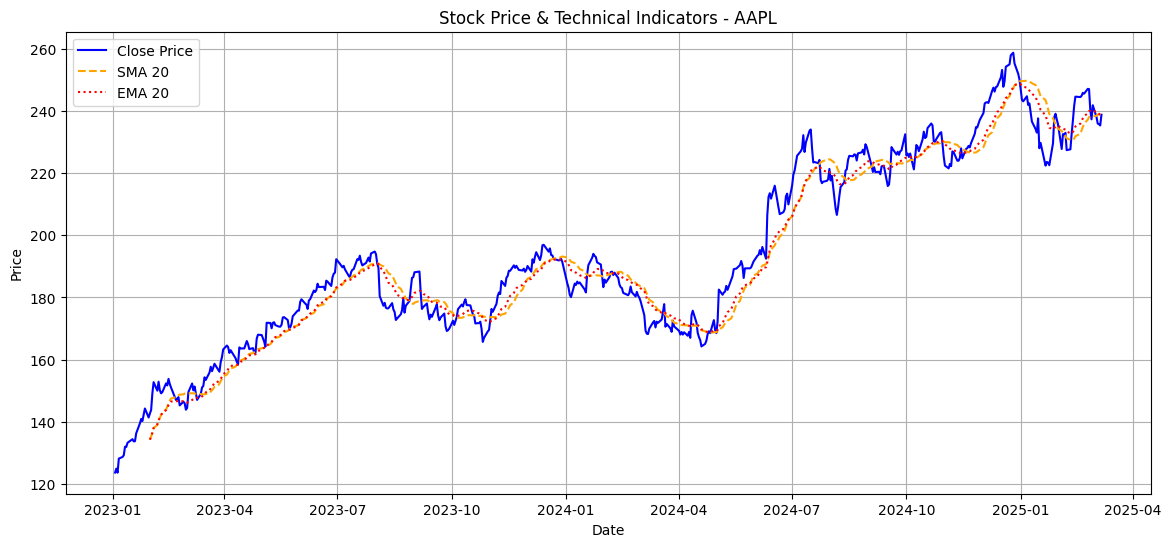

In [6]:
def plot_stock_data(df, ticker):
    """Plots stock price along with technical indicators."""
    plt.figure(figsize=(14, 6))
    
    # Plot closing price
    plt.plot(df["date"], df["close"], label="Close Price", color="blue")
    
    # Plot SMA & EMA
    if "sma_20" in df.columns:
        plt.plot(df["date"], df["sma_20"], label="SMA 20", color="orange", linestyle="dashed")
    if "ema_20" in df.columns:
        plt.plot(df["date"], df["ema_20"], label="EMA 20", color="red", linestyle="dotted")
    
    plt.title(f"Stock Price & Technical Indicators - {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

plot_stock_data(df, ticker)


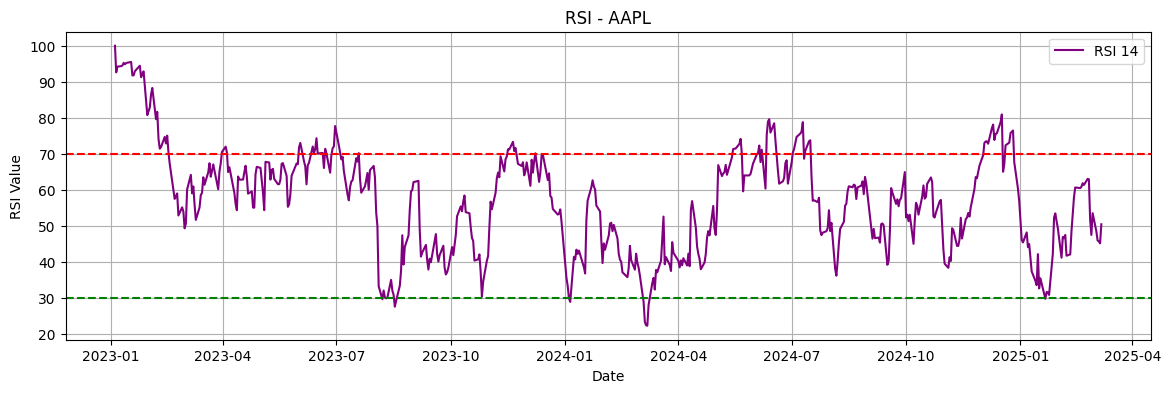

In [7]:
def plot_rsi(df, ticker):
    """Plots RSI for the given stock."""
    plt.figure(figsize=(14, 4))
    plt.plot(df["date"], df["rsi_14"], label="RSI 14", color="purple")
    plt.axhline(70, color="red", linestyle="dashed")
    plt.axhline(30, color="green", linestyle="dashed")
    
    plt.title(f"RSI - {ticker}")
    plt.xlabel("Date")
    plt.ylabel("RSI Value")
    plt.legend()
    plt.grid()
    plt.show()

plot_rsi(df, ticker)


/var/folders/j5/t8_ztn753k55q2jbgyryk3kr0000gn/T/ipykernel_47302/3746322430.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sentiment = pd.read_sql(query, conn)


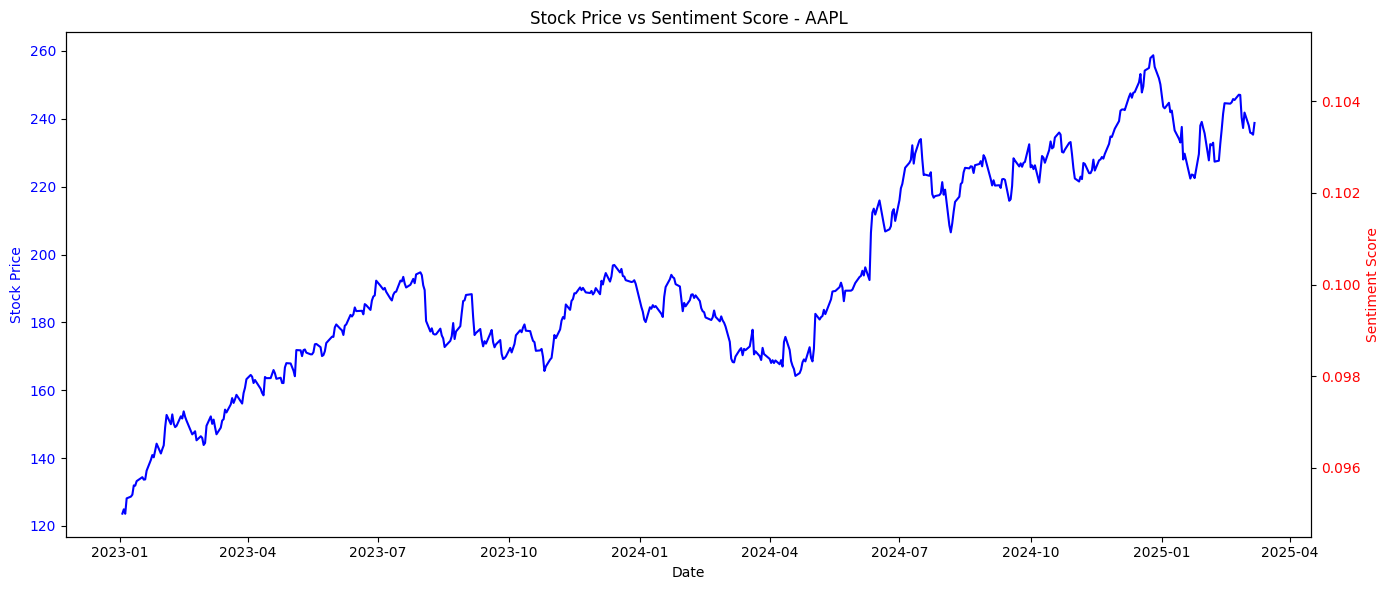

In [8]:
def fetch_sentiment_data(ticker):
    """Fetches sentiment scores from the database."""
    conn = connect_db()
    if not conn:
        return None

    query = f"""
        SELECT published_at, sentiment_score
        FROM news_sentiment
        WHERE ticker = '{ticker}'
        ORDER BY published_at;
    """

    df_sentiment = pd.read_sql(query, conn)
    conn.close()
    return df_sentiment

# Fetch sentiment data
df_sentiment = fetch_sentiment_data(ticker)

# Merge sentiment with stock data based on date
df_sentiment["date"] = pd.to_datetime(df_sentiment["published_at"]).dt.date
df_sentiment_grouped = df_sentiment.groupby("date")["sentiment_score"].mean().reset_index()
df["date"] = df["date"].dt.date  # Convert stock data date to same format
df_merged = pd.merge(df, df_sentiment_grouped, on="date", how="left")

# Plot Sentiment vs Stock Price
def plot_sentiment_vs_stock(df_merged, ticker):
    """Plots stock closing price against sentiment scores."""
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Stock closing price
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Stock Price", color="blue")
    ax1.plot(df_merged["date"], df_merged["close"], label="Close Price", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    # Sentiment score on a second y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel("Sentiment Score", color="red")
    ax2.plot(df_merged["date"], df_merged["sentiment_score"], label="Sentiment Score", color="red", linestyle="dashed")
    ax2.tick_params(axis="y", labelcolor="red")

    plt.title(f"Stock Price vs Sentiment Score - {ticker}")
    fig.tight_layout()
    plt.show()

plot_sentiment_vs_stock(df_merged, ticker)
